# This Notebook reads in all data files from rat trap files for a given directory and processes them

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import pandas as pd
import shutil
import scipy.optimize as op
import avg_bkg_norm_func as fun

## Reading in Data

In [2]:
# can also make a list of directories for more than one sample as a future mod

============== Specify Directory here ==============

In [3]:
directory = 'Rawdata'

==============================================

In [4]:
# checks that the directory exists and throws error if not
assert os.path.exists(f'{directory}/'), f'No directory with the name {directory} in current folder'

make a list of folders in the directory

In [5]:
folder_list = [f for f in os.listdir(directory)]
F = len(folder_list)

print(F)
#print(folder_list)

6


make lists of files in each folder

In [6]:
file_list = []
for i in folder_list:
    #print(i)
    # generates a list of all the alldata files in specified directory
    new_list = [f for f in os.listdir(f'{directory}/{i}') if 'alldata' in f]
    file_list.append(new_list)
    N = len(file_list)  #N gives length of first dimension, the number of folders (samples) in the directroy, N=F from above
print(N)

6


#### Declaring data variables

In [7]:
# Data will be a 3D list that will be [batch number, row, column]
# where the rows and columns are the same from rat trap all data files
Data = []
# Headers will list which column corresponds to which property, i.e. energy or counts per live
Headers = []

# if user doesn't adjust energyregions for plotting and normalizing,
# default setting is set to entire region
start_energy, end_energy = 0, 10e8

In [8]:
# read in every all data file
for folder in folder_list:
    item = file_list[folder_list.index(folder)]
    #print(folder)
    #print(item)
    for filename in item:
        Data.append(np.array(fun.read_alldata_file(f'{directory}/{folder}/{filename}'))) 

# convert list to array
Data = np.array(Data, dtype=float)


To check which columns correspond to which property, print Headers list

In [9]:
Energy = Data[0,:,0] # eV 
avg = []
a = 0

for i in range(N): 
    j = len(file_list[i])
    k = a + j
    counts = Data[a:k,:,8] #counts per live are the 9th colum
    # find average over all batches
    avg.append(np.sum(counts, 0)/j)  
    a += j
        
avg = np.array(avg, dtype=float)
print(len(avg))

6


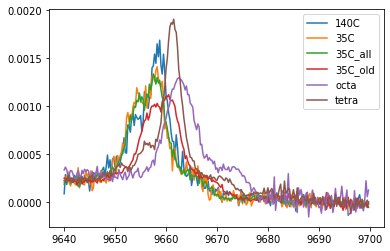

In [10]:
for i in range(len(avg)):   #length of first dimension (no of files)
    avg_c = avg[[i],:]
    avg_cnts = avg_c.flatten()
    #plt.plot(Energy, avg_cnts)
    #write each averaged data to .txt file in the folder 'Averaged & Normalized'
    #filename will be from the name of the folder where the files came from :foldername_avgd
    write = True
    if write:
        fun.write_to_file(Energy, avg_cnts, f'{folder_list[i]}_avgd')
    
    #Specify energy range of interest (ROI) to fit a background here
    start_energy, end_energy = 9689, 9699
    
    #get the indices for ROI to fit background
    start, end = fun.get_E_region(Energy, start_energy, end_energy)

    # takes the last values of the spectrum starting at the specified energy
    y = avg_cnts[start:end] 

    starting_param_vals = np.array([0.0]) #constant background: single parameter fit

    # perform minimization routine
    optimized_background = op.minimize(fun.loss, starting_param_vals, args=(y), method='BFGS')
    #print(optimized_background['message'])
    b = optimized_background['x']
    
    
    #Pick energy range (ROI) to normalize here 
    start_energy, end_energy = 9550, 9600
    #get the indices for ROI to normalize
    E_range = fun.get_E_region(Energy, start_energy, end_energy)

    # Normalize : include constant background subtraction here
    avg_cnts_norm = fun.Normalize(avg_cnts - b, Energy, E_range) 

    #Write normalized data to file
    write = True
    # note: this will overwrite any files with the same name
    # name specified from folder name from whence the batches came from
    if write:
        fun.write_to_file(Energy, avg_cnts_norm, f'{folder_list[i]}_norm')

    #Plot final spectra
    #Pick energy range for plotting here 
    start_energy, end_energy = 9640, 9700
    #get indices for ROI to plot
    start, end = fun.get_E_region(Energy, start_energy, end_energy)
    #fun.plot(Energy[start:end], avg_cnts_norm[start:end], f'Normalized {folder_list[i]} VTC', save=False)
    plt.plot(Energy[start:end], avg_cnts_norm[start:end], label=f'{folder_list[i]}')
    plt.legend()
